In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# https://github.com/leondgarse/keras_efficientnet_v2
!pip install -U keras-efficientnet-v2

In [ ]:
# https://www.tensorflow.org/neural_structured_learning
!pip install --quiet neural-structured-learning

In [ ]:
import keras_efficientnet_v2
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

import neural_structured_learning as nsl

In [ ]:
data_dir = "/content/drive/MyDrive/food"

batch_size = 32
imgSize = 240

splitRate = 0.2

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, seed=123, subset="training", validation_split=splitRate,
  image_size=(imgSize, imgSize), batch_size=batch_size
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, seed=123, subset="validation", validation_split=splitRate,
  image_size=(imgSize, imgSize), batch_size=batch_size
)

classNum = len(train_ds.class_names)
classArr = train_ds.class_names
print(train_ds.class_names)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
  ]
)

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(imgSize, imgSize),
  layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
])

In [ ]:
expendRound = 1
temp_ds = train_ds
for i in range(expendRound):
    train_ds = train_ds.concatenate(temp_ds)

train_ds = train_ds.map(lambda image,label:(data_augmentation(image),label))
train_ds = train_ds.map(lambda image,label:(resize_and_rescale(image),label))


valid_ds = valid_ds.map(lambda image,label:(resize_and_rescale(image),label))

In [ ]:
baseModel = keras_efficientnet_v2.EfficientNetV2B1(pretrained="imagenet21k-ft1k", num_classes=classNum, drop_connect_rate=0.3)
#baseModel = keras_efficientnet_v2.EfficientNetV2B1(pretrained="noisy_student", num_classes=classNum, drop_connect_rate=0.2)

baseModel.trainable = True
print("Layers count", len(baseModel.layers))

# fine_tune_at = int( len(baseModel.layers) * 0) # 0.2
# for layer in baseModel.layers[:fine_tune_at]:
#   layer.trainable = False
  
epochsRound = 5
base_learning_rate = 0.0001

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
adv_model = nsl.keras.AdversarialRegularization(baseModel, adv_config=adv_config)

baseModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = baseModel.fit(train_ds, epochs=epochsRound, validation_data=valid_ds, callbacks=[model_checkpoint_callback] )

baseModel.load_weights(checkpoint_filepath)
test_loss, test_acc = baseModel.evaluate(valid_ds, verbose=2)
print(test_acc)

now = datetime.now()
current_time = now.strftime("%b-%d-%Y_%H:%M:%S")
srt = "/content/drive/MyDrive/savedModel/" + "plant1" + current_time + ".h5"

baseModel.save(srt)
baseModel.save('/content/yoloTest.h5')

33783808/33773048 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-b1-21k-ft1k.h5
Layers count 354
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


46/46 [==============================] - 278s 4s/step - loss: 1.1014 - accuracy: 0.5626 - val_loss: 0.5810 - val_accuracy: 0.8287
Epoch 2/5
46/46 [==============================] - 23s 481ms/step - loss: 0.4630 - accuracy: 0.8384 - val_loss: 0.3046 - val_accuracy: 0.9116
Epoch 3/5
46/46 [==============================] - 23s 492ms/step - loss: 0.3067 - accuracy: 0.9010 - val_loss: 0.2581 - val_accuracy: 0.9282
Epoch 4/5
46/46 [==============================] - 23s 482ms/step - loss: 0.1833 - accuracy: 0.9395 - val_loss: 0.2025 - val_accuracy: 0.9282
Epoch 5/5
46/46 [==============================] - 23s 496ms/step - loss: 0.1541 - accuracy: 0.9525 - val_loss: 0.1702 - val_accuracy: 0.9448
6/6 - 1s - loss: 0.1702 - accuracy: 0.9448 - 670ms/epoch - 112ms/step
0.9447513818740845


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


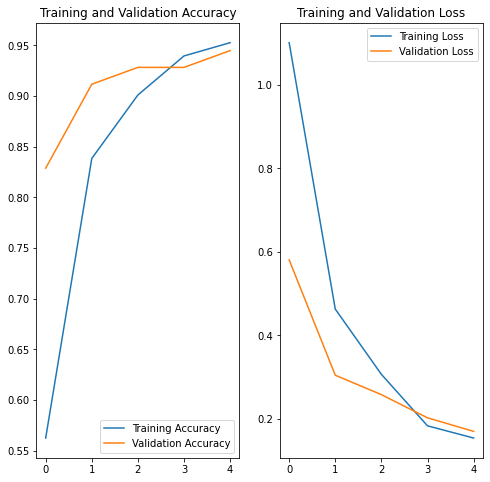

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochsRound)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()